# Types of roles women portray 

#### What types of characters do women portray and how are these roles linked to their physical profiles?

Rather then depicting the real-life women, cinema tends to perpetuate negative gender stereotypes which are reflected in the roles women play in films.
Some of our hypothesis is that women often receive secondary ad stereotypical representation tied to traditional roles of wives, lovers, mothers....
We think also that they are portrayed as overly emotional or dramatic. Women are rarely identified solely by work-related role in cinema, and thus do no really have identifiable occupations.






## Data handling, preprocessing, descriptive statistics 
In this part we wil explore the characters and their types using the dataset availables in **DATA** that we already started to prepocess in a pervious part: **character_metadata,csv** and the already provided data **tvtropes.clusters.txt**.

Features summary and content:

**character_metadata**
* 1. Wikipedia movie ID
* 2. Freebase movie ID
* 3. Movie release date
* 4. Character name
* 5. Actor date of birth
* 6. Actor gender
* 7. Actor height (in meters)
* 8. Actor ethnicity (Freebase ID)
* 9. Actor name
* 10. Actor age at movie release
* 11. Freebase character/actor map ID
* 12. Freebase character ID
* 13. Freebase actor ID

**tvtropes.clusters.txt**

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import re
import seaborn as sns
import ast

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

### Load the data 

In [2]:
# Load the characters dataset
characters = pd.read_csv('Data/character_metadata.csv')

# Load the tropes dataset as a tab-separated file
tropes = pd.read_csv('Data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=['trope', 'data'], engine='python')
# Parse the JSON strings in the 'data' column of the tropes dataset
tropes['data'] = tropes['data'].apply(ast.literal_eval)
# Normalize the 'data' dictionaries into separate columns
data_expanded = pd.json_normalize(tropes['data'])
# Combine the 'trope' column with the expanded data columns
tropes = pd.concat([tropes['trope'], data_expanded], axis=1)


# Load the summaries : read the file into a dataFrame and skips lines with parsing errors
summary = pd.read_csv('Data/MovieSummaries/plot_summaries.txt',sep='\t',header=None, names=['wiki_id', 'summary'], encoding='utf-8', on_bad_lines='skip')
# Convert 'wiki_id' to string 
#summary['wiki_id'] = summary['wiki_id'].astype(str)


#load the ethnicity label dataframe
data_ethnicity = pd.read_csv('Data/cleaned_data/ethnicity_labels.csv')

# Load the IMDb data containing the SuccessMetric
data_imdb = pd.read_csv('Data/cleaned_data/clean_data_imdb.csv')

* Display the first few rows of each dataframe

In [3]:
print("Tropes dataframe:")
tropes.head()

Tropes dataframe:


,trope,char,movie,id,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [4]:
print("\nCharacters dataframe:")
characters.head()


Characters dataframe:


,Wiki_ID,Movie_ID,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie_released,character/actor_ID,character_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
print("Summary dataframe:")
summary.head()

Summary dataframe:


,wiki_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


### Data Understanding and Preprocessing


In [6]:
# Check for missing values, and added the value needed about the gender that was missing 
print("Missing values in tropes dataset:\n", tropes.isnull().sum())


Missing values in tropes dataset:
 trope    0
char     0
movie    0
id       0
actor    0
dtype: int64


###  Data Enrichment
* Enrichment of the tropes dataset with additional characteristics from the characters dataset (e.g., gender, height, ethnicity, age at release).

In [7]:
# Ensure the actor column is named consistently in both DataFrames
characters.rename(columns={'actor_name': 'actor'}, inplace=True)

# Create a dictionary mapping from actor to gender
gender_mapping = characters.set_index('actor')['actor_gender'].to_dict()
height_mapping = characters.set_index('actor')['actor_height'].to_dict()
ethnicity_mapping = characters.set_index('actor')['actor_ethnicity'].to_dict()
age_mapping = characters.set_index('actor')['actor_age_movie_released'].to_dict()

# Use the mapping to add the gender column in tropes based on the actor column
tropes['actor_gender'] = tropes['actor'].map(gender_mapping)
tropes['actor_height'] = tropes['actor'].map(height_mapping)
tropes['actor_ethnicity'] = tropes['actor'].map(ethnicity_mapping)
tropes['actor_age_movie_released'] = tropes['actor'].map(age_mapping)

# Display the updated DataFrame
print("Tropes DataFrame with Gender Column Added:")
tropes.head()

Tropes DataFrame with Gender Column Added:


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0


In [8]:
# Check for the matching column between tropes['id'] and each ID column in characters
matching_column = None
for col in ['character/actor_ID', 'character_ID', 'Actor_ID']:
    if tropes['id'].isin(characters[col]).any():
        matching_column = col
        print(f"Matching column found: {col}")
        break

if matching_column:
    # Perform the merge and directly add the Movie_ID column to the existing tropes DataFrame
    tropes = tropes.merge(
        characters[['Movie_ID', matching_column]],
        left_on='id',
        right_on=matching_column,
        how='left'
    )

# Drop the extra column used for merging if you don’t need it anymore
tropes.drop(columns=[matching_column], inplace=True)

# Rename the Movie_ID column to movie_id in tropes if desired
tropes.rename(columns={'Movie_ID': 'movie_id'}, inplace=True)


# Merge ethnicity label into tropes based on actor_ethnicity and ethnicity_ID
tropes = pd.merge(tropes, data_ethnicity[['ethnicity_ID', 'ethnicity_label']], left_on='actor_ethnicity', right_on='ethnicity_ID', how='left')

# Drop the redundant ethnicity_ID column if it's no longer needed
tropes.drop(columns=['ethnicity_ID'], inplace=True)


# Merge genres into tropes DataFrame based on Movie_ID
tropes = pd.merge(tropes, data_imdb[['Movie_ID', 'Genres', 'SuccessMetric']], left_on='movie_id', right_on='Movie_ID', how='left')

# Drop redundant column if necessary
tropes.drop(columns=['Movie_ID'], inplace=True)

# Explode genres to analyze multi-genre movies
tropes['Genres'] = tropes['Genres'].apply(lambda x: eval(x) if isinstance(x, str) else [])
tropes_exploded = tropes.explode('Genres')

# Display the updated DataFrame
tropes.head()



Matching column found: character/actor_ID


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released,movie_id,ethnicity_label,Genres,SuccessMetric
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0,/m/04vcfx,NaN,"[Science Fiction, Fantasy, Comedy, Family Film...",0.296982
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0,/m/0557n3,NaN,[],NaN
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0,/m/0fjjjh,NaN,"[Thriller, Crime Fiction, Supernatural, Superh...",0.308660
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN,/m/02vt5c,NaN,"[Natural horror films, Science Fiction, Horror...",0.360394
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0,/m/070g7,NaN,"[Thriller, Science Fiction, Action, Sci-Fi Adv...",0.385313


In [9]:
# Check for missing values, and added the value needed about the gender that was missing
print("Missing values in tropes dataset:\n", tropes['actor_gender'].isnull().sum())
tropes.loc[tropes['actor_gender'].isnull(), 'actor_gender'] = 'M'
print("Missing values in tropes dataset:\n", tropes['actor_gender'].isnull().sum())

Missing values in tropes dataset:
 1
Missing values in tropes dataset:
 0


* Fiter: seperate female characters from mens

In [10]:
tropes_w = tropes.loc[tropes['actor_gender'] =='F']
tropes_w.head()


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released,movie_id,ethnicity_label,Genres,SuccessMetric
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz,F,1.70,/m/013b6_,23.0,/m/01ln5z,Ashkenazi Jews,"[Action, Fantasy, Adventure]",0.429745
11,arrogant_kungfu_guy,Jen Yu,"Crouching Tiger, Hidden Dragon",/m/0jwv09,Zhang Ziyi,F,1.63,NaN,28.0,/m/01mgw,NaN,[],NaN
35,brainless_beauty,Gemma Honeycutt,Fool's Gold,/m/04dddz5,Alexis Dziena,F,1.57,/m/0xnvg,18.0,/m/03c_lhp,Italian Americans,"[Romantic comedy, Adventure, Action/Adventure,...",0.304998
38,brainless_beauty,Shelley Darlingson,The House Bunny,/m/04dgw4t,Anna Faris,F,1.65,/m/07bch9,28.0,/m/0408m53,Scottish Americans,"[Romantic comedy, Romance Film, Comedy of mann...",0.287657
39,brainless_beauty,Brace Channing,My Favorite Martian,/m/03lvf22,Elizabeth Hurley,F,1.73,/m/02w7gg,35.0,/m/026hpg_,English people,"[Science Fiction, Family Film, Comedy]",0.261620


In [11]:

tropes_m = tropes.loc[tropes['actor_gender'] =='M']
tropes_m.head()

,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released,movie_id,ethnicity_label,Genres,SuccessMetric
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0,/m/04vcfx,NaN,"[Science Fiction, Fantasy, Comedy, Family Film...",0.296982
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0,/m/0557n3,NaN,[],NaN
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0,/m/0fjjjh,NaN,"[Thriller, Crime Fiction, Supernatural, Superh...",0.308660
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN,/m/02vt5c,NaN,"[Natural horror films, Science Fiction, Horror...",0.360394
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0,/m/070g7,NaN,"[Thriller, Science Fiction, Action, Sci-Fi Adv...",0.385313


### Calculating descriptive statistics 
* let's calculate basic descriptive statistics of the trope

In [12]:
tropes_w['trope'].describe()


count              69
unique             21
top       dumb_blonde
freq               10
Name: trope, dtype: object

In [13]:
print('All the tropes we find women in are\n',tropes_w['trope'].unique())


All the tropes we find women in are
 ['adventurer_archaeologist' 'arrogant_kungfu_guy' 'brainless_beauty'
 'broken_bird' 'bully' 'chanteuse' 'classy_cat_burglar' 'ditz' 'doormat'
 'dumb_blonde' 'eccentric_mentor' 'final_girl' 'granola_person'
 'heartbroken_badass' 'junkie_prophet' 'klutz' 'ophelia' 'prima_donna'
 'slacker' 'storyteller' 'valley_girl']


In [14]:
tropes_m['trope'].describe()

count                   432
unique                   65
top       crazy_jealous_guy
freq                     25
Name: trope, dtype: object

In [15]:
print('All the tropes we find men in are\n',tropes_m['trope'].unique())

All the tropes we find men in are
 ['absent_minded_professor' 'adventurer_archaeologist'
 'arrogant_kungfu_guy' 'big_man_on_campus' 'bounty_hunter'
 'brainless_beauty' 'broken_bird' 'bromantic_foil'
 'bruiser_with_a_soft_center' 'bully' 'byronic_hero' 'casanova' 'charmer'
 'child_prodigy' 'consummate_professional' 'corrupt_corporate_executive'
 'coward' 'crazy_jealous_guy' 'crazy_survivalist' 'cultured_badass'
 'dean_bitterman' 'dirty_cop' 'ditz' 'doormat' 'drill_sargeant_nasty'
 'dumb_blonde' 'dumb_muscle' 'eccentric_mentor' 'egomaniac_hunter'
 'evil_prince' 'fastest_gun_in_the_west' 'father_to_his_men'
 'gadgeteer_genius' 'gentleman_thief' 'granola_person' 'grumpy_old_man'
 'hardboiled_detective' 'heartbroken_badass' 'henpecked_husband'
 'hitman_with_a_heart' 'jerk_jock' 'klutz' 'loser_protagonist'
 'loveable_rogue' 'master_swordsman' 'morally_bankrupt_banker'
 'officer_and_a_gentleman' 'playful_hacker' 'psycho_for_hire'
 'pupil_turned_to_evil' 'retired_outlaw' 'revenge' 'romantic_ru

* Distribution of each trope for both women and men, to see which tropes are more frequently associeted with each gender

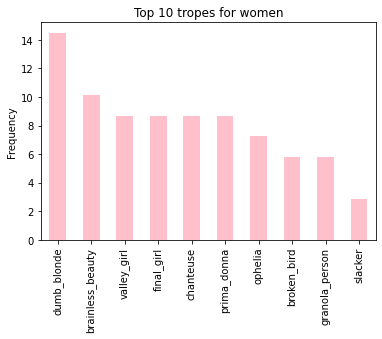

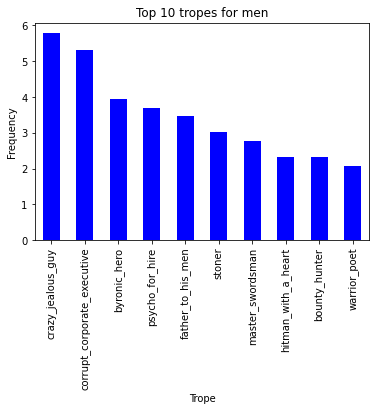

In [16]:
tropes_w_distribution = tropes_w['trope'].value_counts(normalize=True) * 100
tropes_m_distribution = tropes_m['trope'].value_counts(normalize=True) * 100
top_tropes_w = tropes_w_distribution.head(10)
top_tropes_m = tropes_m_distribution.head(10)

# Plotting the top 10 tropes for women and men
top_tropes_w.plot(kind='bar', title='Top 10 tropes for women', color='pink')
plt.ylabel('Frequency')
plt.show()
# Plot the top 10 tropes for men
top_tropes_m.plot(kind='bar', title = 'Top 10 tropes for men',color='blue')
plt.ylabel('Frequency')
plt.xlabel('Trope')
plt.show()

* Average age of actors by tropes, to see if certain tropes are associated with different age groupes

<ipython-input-17-e6d97497df3d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_w['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)
<ipython-input-17-e6d97497df3d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_m['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)


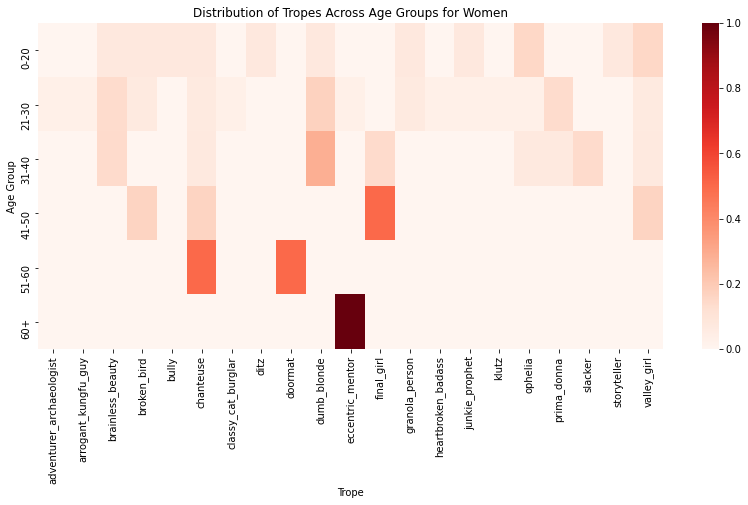

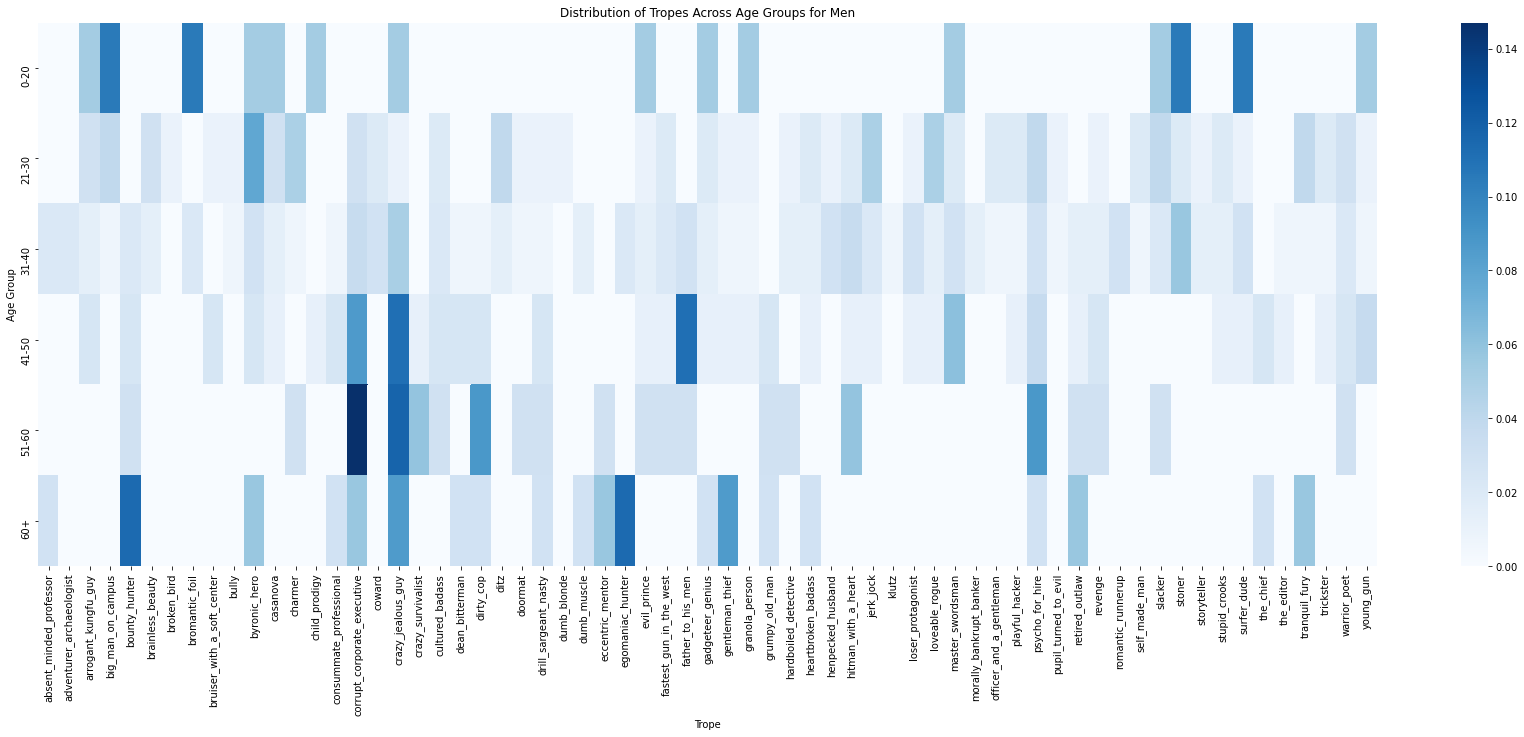

In [17]:
# Categorize age into groups
age_bins = [0, 20, 30, 40, 50, 60, 100]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '60+']
tropes_w['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)
tropes_m['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)

#  distribution of tropes within each age group
tropes_by_age_group_w = tropes_w.groupby(['age_group', 'trope']).size().unstack(fill_value=0)
tropes_by_age_group_m = tropes_m.groupby(['age_group', 'trope']).size().unstack(fill_value=0)

# normalize within each age group to get the proportion of each trope
tropes_by_age_group_w = tropes_by_age_group_w.div(tropes_by_age_group_w.sum(axis=1), axis=0)
tropes_by_age_group_m = tropes_by_age_group_m.div(tropes_by_age_group_m.sum(axis=1), axis=0)


plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_age_group_w, cmap='Reds', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Age Groups for Women")
plt.xlabel("Trope")
plt.ylabel("Age Group")
plt.show()

#Plot the heatmap for men
plt.figure(figsize=(30, 10))
sns.heatmap(tropes_by_age_group_m, cmap='Blues', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Age Groups for Men")
plt.xlabel("Trope")
plt.ylabel("Age Group")
plt.show()

* Average Height by Trope

<ipython-input-18-acde6ea43e23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_w['height_group'] = pd.cut(tropes_w['actor_height'], bins=height_bins_women, labels=height_labels_women)
<ipython-input-18-acde6ea43e23>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_m['height_group'] = pd.cut(tropes_m['actor_height'], bins=height_bins_men, labels=height_labels_men)


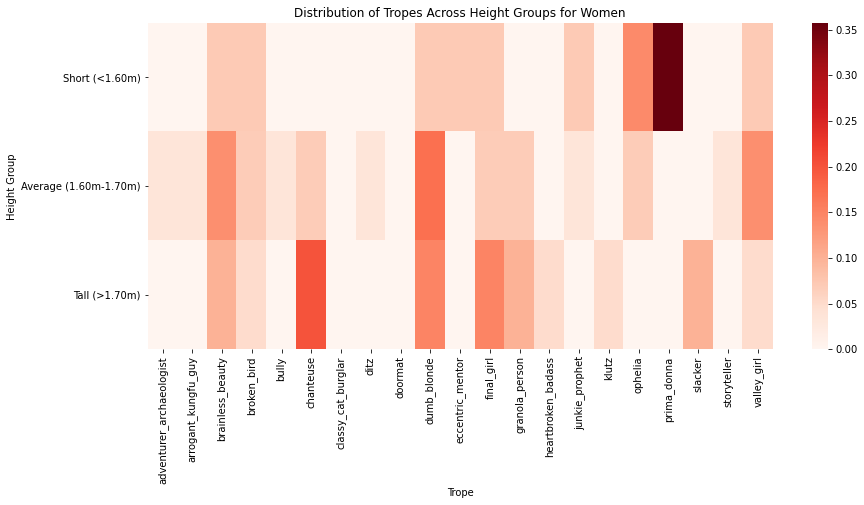

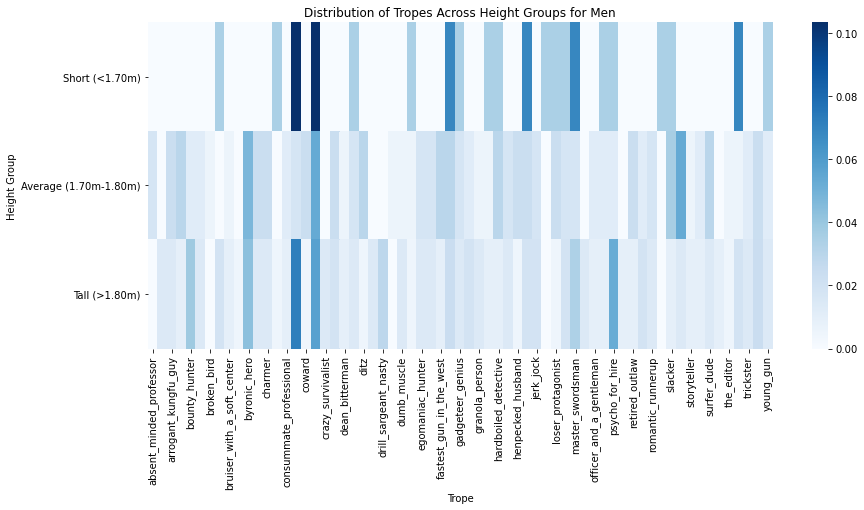

In [18]:
# Define height bins and labels for women
height_bins_women = [0, 1.60, 1.70, float('inf')]
height_labels_women = ['Short (<1.60m)', 'Average (1.60m-1.70m)', 'Tall (>1.70m)']
tropes_w['height_group'] = pd.cut(tropes_w['actor_height'], bins=height_bins_women, labels=height_labels_women)

# Define height bins and labels for men
height_bins_men = [0, 1.70, 1.80, float('inf')]
height_labels_men = ['Short (<1.70m)', 'Average (1.70m-1.80m)', 'Tall (>1.80m)']
tropes_m['height_group'] = pd.cut(tropes_m['actor_height'], bins=height_bins_men, labels=height_labels_men)

# Calculate the distribution of tropes within each height group for women
tropes_by_height_group_w = tropes_w.groupby(['height_group', 'trope']).size().unstack(fill_value=0)
tropes_by_height_group_w = tropes_by_height_group_w.div(tropes_by_height_group_w.sum(axis=1), axis=0)

# Calculate the distribution of tropes within each height group for men
tropes_by_height_group_m = tropes_m.groupby(['height_group', 'trope']).size().unstack(fill_value=0)
tropes_by_height_group_m = tropes_by_height_group_m.div(tropes_by_height_group_m.sum(axis=1), axis=0)

# Plot heatmap for women
plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_height_group_w, cmap='Reds', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Height Groups for Women")
plt.xlabel("Trope")
plt.ylabel("Height Group")
plt.show()

# Plot heatmap for men
plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_height_group_m, cmap='Blues', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Height Groups for Men")
plt.xlabel("Trope")
plt.ylabel("Height Group")
plt.show()

* Ethnicity Distribution by Trope (we need to enrich our dataframe as the actor ethnicity need to be defined (many nan)


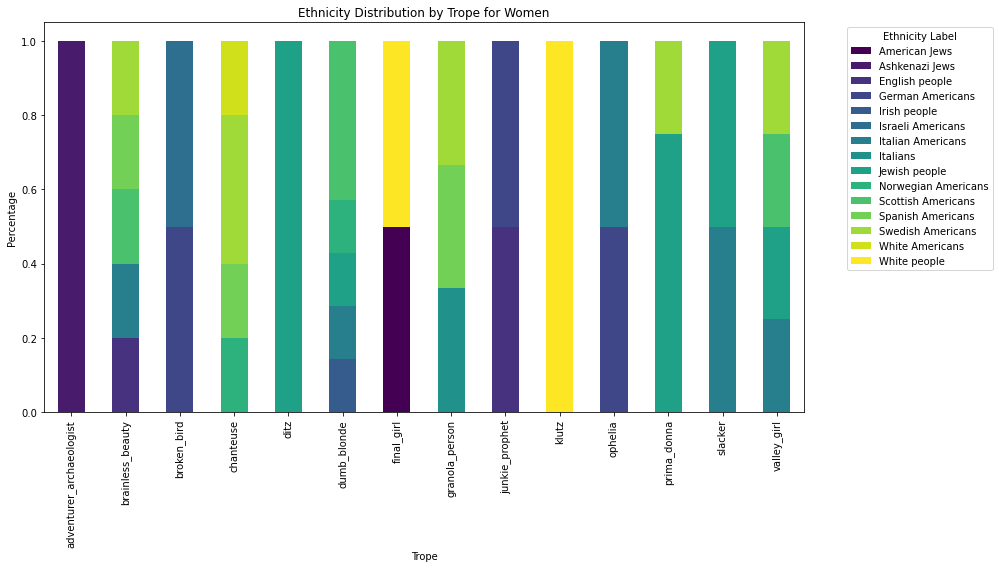

In [19]:
# Calculate the normalized distribution of ethnicity labels per trope for women
ethnicity_distribution_w = tropes_w.groupby('trope')['ethnicity_label'].value_counts(normalize=True).unstack().fillna(0)

# Calculate the normalized distribution of ethnicity labels per trope for men
ethnicity_distribution_m = tropes_m.groupby('trope')['ethnicity_label'].value_counts(normalize=True).unstack().fillna(0)

# Display the distributions

ethnicity_distribution_w.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title("Ethnicity Distribution by Trope for Women")
plt.xlabel("Trope")
plt.ylabel("Percentage")
plt.legend(title="Ethnicity Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


* try to classify the tropes into different categories 


In [20]:
# Chi-square test for gender and trope association
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(tropes['actor_gender'], tropes['trope'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test:")
print("Chi2 Statistic:", chi2)
print("P-value:", p)


Chi-square Test:
Chi2 Statistic: 370.6327138709386
P-value: 4.0674589101657184e-42


Since the p-value is significantly less than 0.05, we reject the null hypothesis that gender and trope type are independent of each other. This suggests that there is a significant association between gender and the types of tropes characters are assigned to in movies.

low p-value that indicate that there are significant differences in mean age among the groups.

Low p-value that suggest that the difference in proportions is statistically significant, meaning the proportion of men in "brainless_beauty" differs significantly from the proportion of women in "dumb_blonde."

### Correlation between  women trope and the success of a movie : 

In [23]:

# Group by trope and calculate the average success for each trope
trope_success = tropes_w.groupby('trope')['SuccessMetric'].mean().reset_index()
# Calculate the correlation between each trope's success metric and movie success
correlation = trope_success['SuccessMetric'].corr(tropes_w['SuccessMetric'])

print(f"Correlation between tropes played by women and movie success: {correlation}")

# Display top tropes associated with high success
top_tropes = trope_success.sort_values(by='SuccessMetric', ascending=False).head(10)
print("Top Tropes Correlated with Success:")
print(top_tropes)
worst_tropes = trope_success.sort_values(by='SuccessMetric', ascending=True).head(10)
print("Worst Tropes Correlated with Success:")
print(worst_tropes)

Correlation between tropes played by women and movie success: nan
Top Tropes Correlated with Success:
                       trope  SuccessMetric
0   adventurer_archaeologist       0.429745
5                  chanteuse       0.400347
15                     klutz       0.395250
11                final_girl       0.387960
14            junkie_prophet       0.379077
17               prima_donna       0.374087
6         classy_cat_burglar       0.370807
16                   ophelia       0.366663
10          eccentric_mentor       0.366290
19               storyteller       0.361918
Worst Tropes Correlated with Success:
                 trope  SuccessMetric
4                bully       0.262706
2     brainless_beauty       0.283412
9          dumb_blonde       0.317305
18             slacker       0.320252
13  heartbroken_badass       0.322214
20         valley_girl       0.324554
12      granola_person       0.347549
3          broken_bird       0.352333
7                 ditz       0.355

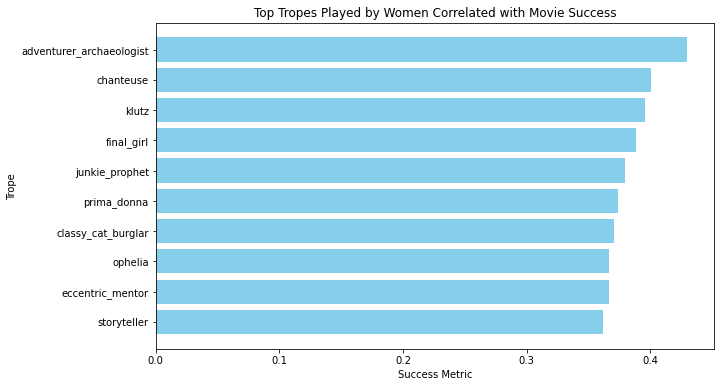

In [24]:
# Plot the top tropes associated with high success
plt.figure(figsize=(10, 6))
plt.barh(top_tropes['trope'], top_tropes['SuccessMetric'], color='skyblue')
plt.xlabel('Success Metric')
plt.ylabel('Trope')
plt.title('Top Tropes Played by Women Correlated with Movie Success')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


#### Interpretation:
correlation between the tropes played by women and the movie success metric is between 0.2 and 0,42 approximatively. This is a moderate positive correlation, indicating that while certain tropes may be slightly associated with higher success, the overall influence of tropes on success is not strong. This suggests that other factors might play a more significant role in determining movie success, such as plot, cast, production quality, and marketing, also play significant roles in determining a movie's success.
 This correlation could imply that movies with female characters in adventurous or "heroic" roles are somewhat more likely to perform well. This aligns with a broader trend in cinema where empowered, proactive female characters have gained popularity, appealing to modern audiences who appreciate diverse and dynamic representations. lthough a correlation of 0.4 is notable, it does not imply causation. This trope might be associated with other successful elements, such as being part of action-adventure genres, which traditionally perform well at the box office.
 

In [25]:
tropes.head()

,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released,movie_id,ethnicity_label,Genres,SuccessMetric,trope_encoded
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0,/m/04vcfx,NaN,"[Science Fiction, Fantasy, Comedy, Family Film...",0.296982,0
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0,/m/0557n3,NaN,[],NaN,0
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0,/m/0fjjjh,NaN,"[Thriller, Crime Fiction, Supernatural, Superh...",0.308660,0
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN,/m/02vt5c,NaN,"[Natural horror films, Science Fiction, Horror...",0.360394,0
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0,/m/070g7,NaN,"[Thriller, Science Fiction, Action, Sci-Fi Adv...",0.385313,0


### Regression analysis 
To explore and quantify the relationship between female character tropes, movie characteristics (such as genre, age, and ethnicity), and movie success. To try and answer he following question :
 * Do certain female tropes correlate with higher movie success?
 We suspect that certain female tropes, like "adventurer_archaeologist" or "final_girl," might be associated with more successful movies. Regression allows us to measure how much each trope contributes to the success metric, even when other factors are considered.
 * Does the impact of a trope depend on the genre, age, or ethnicity of the character?
 Success might vary across genres, age groups, or ethnicities. For example, an "adventurous" trope might perform better in action genres, or characters of certain ages or ethnic backgrounds might resonate more with audiences in particular tropes. By including these variables, regression helps us understand whether success depends on a combination of these factors.
 * Is the relationship statistically significant?
 The regression analysis provides also statistical significance (p-values). A significant result suggests that the observed effect of a trope, genre, or other factor on success is unlikely to be due to chance, giving us more confidence in our findings.

In [26]:
import statsmodels.api as sm
# Explode the Genres column to ensure each row has only one genre
tropes_w_exploded = tropes_w.explode('Genres')

# Drop rows with missing values in SuccessMetric, actor_age_movie_released, or ethnicity_label if necessary
tropes_w_exploded = tropes_w_exploded.dropna(subset=['SuccessMetric', 'actor_age_movie_released', 'ethnicity_label'])

# One-hot encode genres, tropes, and ethnicity labels
genre_encoded = pd.get_dummies(tropes_w_exploded['Genres'], prefix='Genre')
trope_encoded = pd.get_dummies(tropes_w_exploded['trope'], prefix='Trope')
ethnicity_encoded = pd.get_dummies(tropes_w_exploded['ethnicity_label'], prefix='Ethnicity')

# Combine all features, including 'actor_age_movie_released' as an independent variable
data_for_regression = pd.concat(
    [tropes_w_exploded[['SuccessMetric', 'actor_age_movie_released']].reset_index(drop=True),
     genre_encoded.reset_index(drop=True),
     trope_encoded.reset_index(drop=True),
     ethnicity_encoded.reset_index(drop=True)],
    axis=1
)

# Define X (independent variables) and y (dependent variable)
X = data_for_regression.drop(columns=['SuccessMetric'])
y = data_for_regression['SuccessMetric']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          SuccessMetric   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     37.91
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           9.71e-53
Time:                        22:57:29   Log-Likelihood:                 578.58
No. Observations:                 183   AIC:                            -1003.
Df Residuals:                     106   BIC:                            -756.0
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

C:\Users\Myriam Charfeddine\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


* Interpretation 

R-squared: 
0.965, the model explains 96.5% of the variance in the SuccessMetric. This suggests that the predictors (age, genre, tropes, and ethnicity) together provide a strong explanation for movie success.

Adjusted R-squared:
0.939, high value his value accounts for the number of predictors in the model, suggesting that even with many predictors, the model is robust.P-values and Significance:
The coefficients with a p-value less than 0.05 are statistically significant, suggesting a reliable effect on the SuccessMetric.
For example:
Genre_Comedy of manners has a p-value of 0.049, indicating a marginally significant positive effect on movie success.
Other genres or tropes with higher p-values indicate that they do not have a statistically significant relationship with the SuccessMetric in this model.

Coefficients:
Positive coefficients indicate that a variable is associated with higher movie success, while negative coefficients suggest an association with lower success.
For instance:
const: This is the intercept, or baseline level of success when all predictors are zero.

Model Diagnostics:
Durbin-Watson: 0.873, which suggests possible positive autocorrelation in the residuals. Ideally, this should be closer to 2 for no autocorrelation.
Condition Number: 2.01e+18, which is very high, indicating potential multicollinearity. This suggests that some predictor variables may be highly correlated with each other.

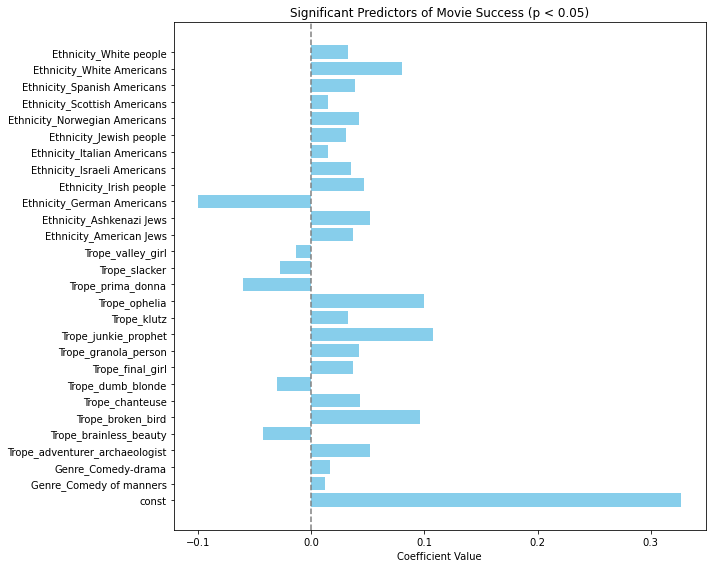

In [27]:
# Extract significant coefficients (p < 0.05)
significant_vars = model.summary2().tables[1]
significant_vars = significant_vars[significant_vars['P>|t|'] < 0.05]

# Plot the coefficients of significant variables
plt.figure(figsize=(10, 8))
plt.barh(significant_vars.index, significant_vars['Coef.'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Significant Predictors of Movie Success (p < 0.05)')
plt.axvline(0, color='gray', linestyle='--')  # Add a vertical line at 0 for reference
plt.tight_layout()
plt.show()

Each bar represents a variable's coefficient, showing its influence on the success metric. 
Positive coefficients, Prima Donna, Final Girl, and Junkie Prophet are notable tropes positively associated with movie success. These tropes may resonate with audiences, possibly due to their complexity or emotional depth. Comedy-drama and Comedy of manners stand out as genres associated with higher success metrics, implying that movies in these genres might be more successful.
Less successful tropes: Brainless Beauty and Chanteuse have negative associations with success. This could indicate that audiences may find these tropes less appealing or outdated.

